In [10]:
import pandas as pd
import os
import numpy as np
from scipy import signal
from mne.filter import resample

def filter_signal(dat:np.ndarray, 
                  band=[1,50], 
                  sampling_rate:int=500):
    # data: 1D array
    [b, a] = signal.iirnotch(60, 30, sampling_rate) # power noise
    dat = signal.filtfilt(b, a, dat)
    [b, a] = signal.butter(3, band, 'bandpass', fs=sampling_rate)
    dat = signal.filtfilt(b, a, dat)
    # dat =  np.convolve(dat, np.ones(sampling_rate//20) / (sampling_rate//20), mode='same')
    return dat

def preprocess_mist_data(path:str, fs:int=125):
    ROOT_PATH = path + '/Day 1/'
    subj_list = os.listdir(ROOT_PATH)
    print(subj_list)

    eeg_resting = []
    eeg = []
    eeg_med = []
    eeg_task = []


    for idx, subj in enumerate(subj_list):
        dat_list = os.listdir(ROOT_PATH+subj)
        if idx == 0:
            continue
        # print(subj, dat_list[0])
        if idx < 5:
            easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[2], delimiter='\t'), float).T
        else:
            easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[3], delimiter='\t'), float).T 
        easy = easy_[:8,0::2] / 1e3
        easy = resample(easy, down=500//fs)
        easy = filter_signal(easy, sampling_rate=125)

        event1 = np.where((0 < easy_[8]) & (easy_[8] < 10))[0] // 8
        event2 = np.where((10 <= easy_[8]) & (easy_[8] <= 20))[0] // 8
        # print(f'{idx} {easy[:,event1[0]:event2[-1]].shape}')
        if idx in [1,5,10,11]: # 0,9없음 / 4,10안맞음
            # savedata 없음         
            diff = np.diff(event2)
            i = np.where(diff > 1250)[0][-1]
            # print(f"train {easy[:,event1[0] : event2[i]].shape}")
            # print(f"test {easy[:,event1[event1 < event2[i+1]][-1] : event2[-1]].shape}") # test
            temp1 = easy[:,event1[0] : event2[i]]
            temp2 = easy[:,event1[event1 < event2[i+1]][-1] : event2[-1]]
        else:
            t1 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_train.csv'), float).shape[0]+1
            t2 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_test.csv'), float).shape[0]+1

            # print(f"train {easy[:,event1[0] : event2[t1-1]].shape}")
            # print(f"test {easy[:,event1[event2[t1-1] < event1][0] : event2[-1]].shape}") # test
            temp1 = easy[:,event1[0] : event2[t1-1]]
            temp2 = easy[:,event1[event2[t1-1] < event1][0] : event2[-1]]
        
        eeg_task.append(np.stack([temp1[:, -fs*150:], temp2[:, -fs*150:]]))

        event_r = np.where(easy_[8] == 90)[0] // 8
        eeg_resting.append(easy[:,event_r[0]:event_r[0]+fs*210]) # rs 1
        eeg.append(np.stack([easy[:,event_r[1]:event_r[1]+fs*60], easy[:,event_r[2]:event_r[2]+fs*60]],0)) # rs 2, rs 3
        
        event_m = np.where(easy_[8]==120)[0][0] // 8
        eeg_med.append(easy[:,event_m - fs*300 : event_m]) # meditation

    eeg_task = np.stack(eeg_task, 0)
    eeg = np.stack(eeg, 0)
    eeg_resting = np.stack(eeg_resting, 0)
    eeg_med = np.stack(eeg_med, 0)
    label = np.zeros(eeg.shape[0:2])
    label[:,0] = 1

    np.savez_compressed(f'{path}/mist/mist.npz', 
                        eeg=eeg, 
                        eeg_task=eeg_task, 
                        eeg_med=eeg_med, 
                        eeg_resting=eeg_resting, 
                        label=label
                        )

preprocess_mist_data('D:/One_한양대학교/private object minsu/coding/data/samsung_2024')

['02.YBJ', '03.JHS', '04.HJH', '05.LHS', '06,KAY(W)', '07.HSY', '08.KHJ(W)', '09.LGY(W)', '10.PJU', '11.KMJ(W)', '12.KJG(W)', '13.LHJ', '14.YSA', '15.KHI(W)', '16.CHJ(W)', '17.PCG', '18.ASJ(W)', '19.RWO', '20.CYS', '21.HDE(W)', '22.SMS', '23.LHJ', '24.OJM', '25.SJH(W)', '26.HYJ(W)', '27.KTH(W)', '28.JMY(W)', '29.SSJ', '30.KHW', '31.PYJ(W)', '32.JMK(W)', '33.CYR']


In [11]:
import numpy as np
mist = np.load('D:/One_한양대학교/private object minsu/coding/data/samsung_2024/mist/mist.npz')
print(mist['eeg'].shape)
print(mist['eeg_task'].shape)
print(mist['eeg_med'].shape)
print(mist['eeg_resting'].shape)
print(mist['label'].shape)

(31, 2, 8, 7500)
(31, 2, 8, 18750)
(31, 8, 37500)
(31, 8, 26250)
(31, 2)


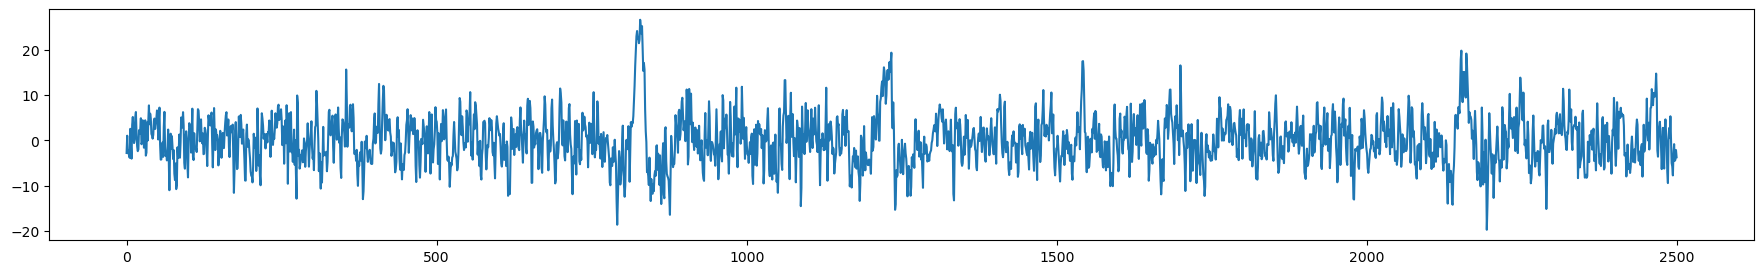

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,3))
plt.plot(mist['eeg'][0,1,7,5000:])

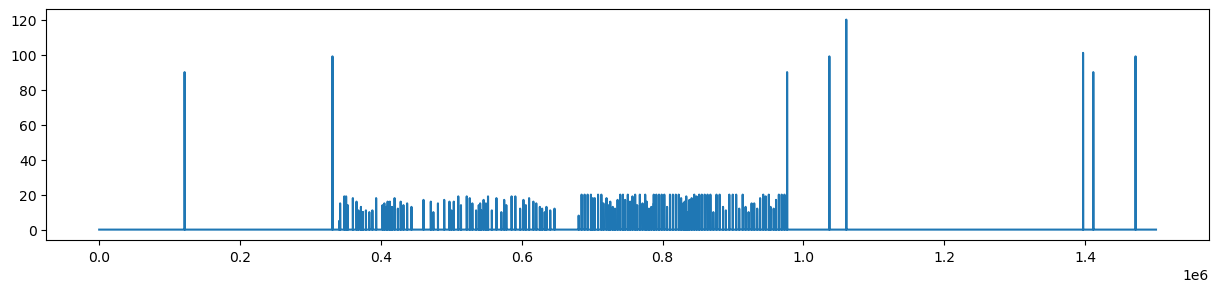

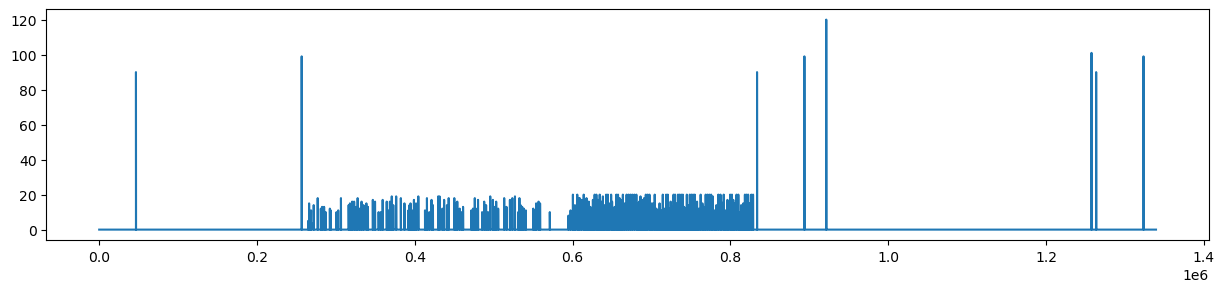

In [11]:
import matplotlib.pyplot as plt

path = 'D:/One_한양대학교/private object minsu/coding/data/samsung_2024'
ROOT_PATH = path + '/Day 1/'
subj_list = os.listdir(ROOT_PATH)

plt.figure(figsize=(15,3))
subj = subj_list[0]
dat_list = os.listdir(ROOT_PATH+subj)
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[2], delimiter='\t'), float).T
plt.plot(easy_[8])

plt.figure(figsize=(15,3))
subj = subj_list[4]
dat_list = os.listdir(ROOT_PATH+subj)
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[3], delimiter='\t'), float).T
plt.plot(easy_[8])

In [26]:
event1 = np.where((0 < easy_[8]) & (easy_[8] < 10))[0]
event2 = np.where((10 <= easy_[8]) & (easy_[8] <= 20))[0]

diff = np.diff(event2)
i = np.where(diff > 15000)[0][-1]
len(event1), len(event2), event2[i], (event2[-1] - event1[event1 < event2[i+1]][-1])/60000, (event2[i] - event1[0])/60000, event2[i-1], event2[i], event2[i+1], 

IndexError: index -1 is out of bounds for axis 0 with size 0

IndexError: index -224 is out of bounds for axis 0 with size 219

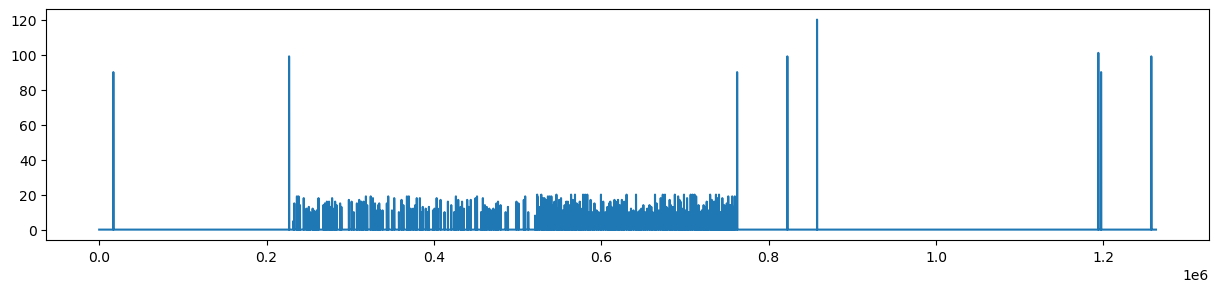

In [27]:
# for i in range(13,32):
plt.figure(figsize=(15,3))
subj = subj_list[10]
dat_list = os.listdir(ROOT_PATH+subj)
easy_ = np.asarray(pd.read_csv(ROOT_PATH + subj + '/' + dat_list[3], delimiter='\t'), float).T
t1 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_train.csv'), float).shape[0]+1
t2 = np.asarray(pd.read_csv(ROOT_PATH + subj + '/savedata_test.csv'), float).shape[0]+1

event1 = np.where((0 < easy_[8]) & (easy_[8] < 10))[0]
event2 = np.where((10 <= easy_[8]) & (easy_[8] <= 20))[0]

# print((event2[t1-1] - event1[0])/60000, (event2[-1] - event1[event2[t1-1] < event1][0])/60000)
plt.plot(easy_[8])

print(event2[t1-1], event1[0], event2[-1], event2[-t2])
len(event1), len(event2), t1+t2, event2, (event2[t1-1] - event1[0])/60000, (event2[-1] - event1[event2[t1-1] < event1][0])/60000